**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

For windows simply add it to system PATH.

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio1210\\cplex\\python\\3.6\\x64_win64\\cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Constants

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300

N_choices_ori = family_id_choice_to_pref_cost.shape[1]  # 11

# constant objects
families = range(N_families)
days = range(1, N_days + 1)
allowed_occupancy = range(N_min_people, N_max_people + 1)
possible_family_sizes = np.unique(n_people)
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

## Parameters

In [4]:
path_init_conf =     '../output/m20-improved-4.csv'
path_dump_improved = '../output/m21-improved.csv' # output solution

num_cpu_cores = 4
time_limit = 5*60  # time limit per loop in s 

## Read initial solution

In [5]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     69652.011085299
Preference cost: 64015
Accounting cost: 5637.011085299005


### Occupancy

In [6]:
print(occupancy, occupancy.shape)

[125 300 288 300 300 285 263 249 249 269 296 300 297 273 262 254 273 296
 294 275 247 223 228 256 283 300 292 273 258 251 246 275 279 256 224 196
 167 192 227 251 236 206 176 160 125 294 276 251 219 188 156 125 282 260
 231 195 160 127 125 263 238 205 163 125 125 125 246 219 183 139 125 125
 125 225 206 173 128 125 125 125 229 211 181 138 126 125 125 253 231 199
 157 125 125 125 225 204 171 126 125 125 125 125] (102,)


In [7]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

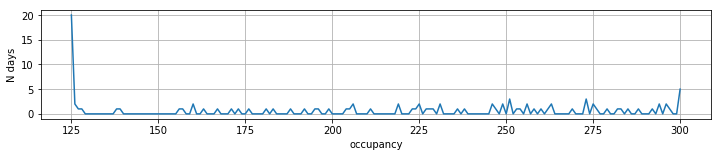

In [8]:
plt.figure(figsize=(12, 2))
plt.plot(init_occupancy_counts); plt.xlabel('occupancy'); plt.ylabel('N days')
plt.ylim(-1, init_occupancy_counts.max()+1); plt.grid(); plt.show()

In [9]:
accounting_cost_per_day = pd.Series({
    day: nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
})

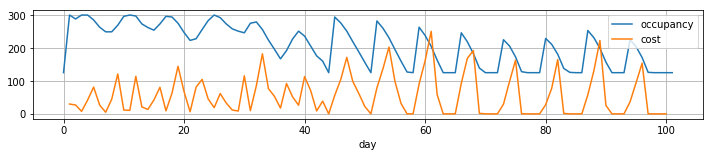

In [10]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.legend(); plt.grid(); plt.show()

In [11]:
print(max(accounting_cost_per_day), accounting_cost_per_day)

250.48410034179688 1       29.788443
2       26.920185
3        7.577722
4       41.944504
5       81.210869
          ...    
96     153.777359
97       0.030912
98       0.000000
99       0.000000
100      0.000000
Length: 100, dtype: float64


### Family preferred days

In [12]:
day_rank_count = np.zeros((10, N_days+1), dtype='int32')

In [13]:
for r in range(10):
    family_pref_r = family_pref[:, r]
    for day, size in zip(family_pref_r, n_people):
        day_rank_count[r, day] += size

In [14]:
#day_rank_count

In [15]:
day_rank_acc_count = np.zeros((10, N_days+1), dtype='int32')
for rank_acc in range(10):
    day_rank_acc_count[rank_acc] = day_rank_count[rank_acc]
    for r in range(1, rank_acc + 1):
        day_rank_acc_count[rank_acc] += day_rank_count[r]

In [16]:
#day_rank_acc_count

In [17]:
# plt.figure(figsize=(14, 6))
# for i in range(5):
#     row = day_rank_acc_count[i]
#     plt.plot(row, label=str(i))
# plt.plot([N_max_people]*N_days, label='max')
# plt.plot([N_min_people]*N_days, label='min')
# plt.ylim(-10, 2000)
# plt.grid(); plt.legend(); plt.show()

In [18]:
# plt.figure(figsize=(14, 6))
# for i in range(5):
#     row = day_rank_acc_count[i]
#     plt.plot(row, label=str(i))
# plt.plot([N_max_people]*N_days, label='max')
# plt.plot([N_min_people]*N_days, label='min')
# plt.plot(occupancy, label='occupancy')
# plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
# plt.ylim(-10, 500)
# plt.grid(); plt.legend(); plt.show()

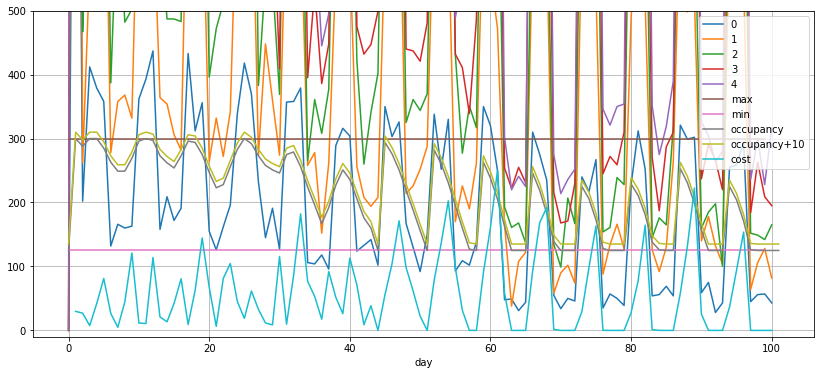

In [19]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(occupancy+10, label='occupancy+10')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

## Setup

### Experiment parameters

In [20]:
N_families - 62868 / 50  # minimum family on choice 0 for the optimal solution

3742.6400000000003

In [21]:
use_hint = True      # use current input as hint
occupancy_count_as_variables = False  # use occupancy_counts as variable (seem faster)
redundant_occupancy_constraints = True  # use redundant constraints
min_choice_0_families = 3742   # minimum number of families that are at their choice 0
target_pref_cost = 0 # 62868
target_pref_cost_error = 0
target_pref_cost_lower = 62867
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 0
target_accounting_cost_lower = 5554

### Search occupancy

In [22]:
def build_search_occupancy(occupancy, occupancy_diff, occupancy_diff_low):
    # limit the occupancy choice to +- occupancy_diff of current solution
    search_occupancy = {}
    for day in days:
        if day == 1:
            search_occupancy[day] = [N_max_people]
        elif day == N_days:
            search_occupancy[day] = [N_min_people]
        elif occupancy[day] == N_min_people:
            search_occupancy[day] = range(N_min_people, occupancy[day] + occupancy_diff_low + 1)
        else:
            search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people),
                                          min(occupancy[day] + occupancy_diff, N_max_people) + 1)
    return search_occupancy

In [23]:
def build_viable_nd_ndp1(max_accounting_cost_per_day):
    # occupancy pairs [o, o_next] limited by accounting cost
    return nd_ndp1_to_account_penality <= max_accounting_cost_per_day

In [24]:
def compute_N_choices(max_family_rank):
    # Possible choice for the family
    # last choice is any day that is not on the family's preferred days
    N_choices = min(N_choices_ori, max_family_rank)
    print('Limit family choice rank:', N_choices_ori, '->', N_choices)
    return N_choices

#### Check

In [25]:
def check_search_occupancy(search_occupancy, occupancy, day_rank_acc_count=[]):
    plt.figure(figsize=(14, 6))
    plt.plot(occupancy, label='occupancy')
    plt.plot(pd.Series({d: max(v) for d, v in search_occupancy.items()}), label='max_search_occupancy')
    plt.plot(pd.Series({d: min(v) for d, v in search_occupancy.items()}), label='min_search_occupancy')
    for i, row in enumerate(day_rank_acc_count):
        plt.plot(row, label=str(i), alpha=0.7)
    plt.plot([N_max_people]*N_days, label='max', alpha=0.3)
    plt.plot([N_min_people]*N_days, label='min', alpha=0.3)
    plt.ylim(-10, 500)
    plt.grid(); plt.legend(); plt.show()

In [26]:
def check_viable_nd_ndp1(viable_nd_ndp1):
    print(viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum())
    plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
    plt.xlim(N_min_people, N_max_people); plt.ylim(N_min_people, N_max_people)

## DOCplex model

In [27]:
from docplex.mp.model import Model

In [28]:
def build_days_family_prefered(N_family_pref, family_pref):
    # day to dictionary of families who choose this day with value as preference rank
    days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

    for family, pref in enumerate(family_pref):
        for rank, day in enumerate(pref):
            if rank < N_family_pref:
                days_family_prefered[day][family] = rank
    return days_family_prefered

In [29]:
def solve_cplex_model(time_limit, search_occupancy, viable_nd_ndp1, N_choices):
    # ==== Create DOCplex model ====
    solver = Model('')
    if num_cpu_cores > 0:
        solver.context.cplex_parameters.threads = num_cpu_cores
        print('Set num threads:', num_cpu_cores)
    print('Num treads:', solver.context.cplex_parameters.threads)
    if time_limit > 0:
        print('Set time limit:', solver.set_time_limit(time_limit))
    solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0
    
    # ==== Variables ====
    # assignment matrix[family, pref_rank]
    assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')
    print('assignment_matrix size:', len(assignment_matrix))
    
    # unpreferred_day_counts[day, size]
    if N_choices_ori <= N_choices:
        print('using unpreferred day counts')
        ub = int(N_max_people / possible_family_sizes.min())
        unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, 
                                                           lb=0, ub=ub, name='d')
        print(len(unpreferred_day_counts))
    else:
        unpreferred_day_counts = None
    
    # occupancy matrix [day, N_d, N_d+1]
    occupancy_keys_list = []
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    if viable_nd_ndp1[o, o_next]:
                        occupancy_keys_list.append((day, o, o_next))
        else:
            # last day
            for o in search_occupancy[day]:
                if viable_nd_ndp1[o, o]:
                    occupancy_keys_list.append((day, o))
    occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')
    print('occupancy_matrix size:', len(occupancy_matrix))
    
    # ==== Constraints ====
    # constraint 1: each family only take one day (choice)
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
        for family in families
    ])
    
    # constraint: choices limit
    if min_choice_0_families > 0:
        solver.add_constraint_(
            solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
        )
    
    # constraint: occupancy and assignment_matrix
    N_family_pref = min(N_choices, N_choices_ori - 1)
    print('N_family_pref:', N_family_pref)
    
    # day to dictionary of families who choose this day with value as preference rank
    days_family_prefered = build_days_family_prefered(N_family_pref, family_pref)
    
    # occupancy count [intermediate variables]
    if occupancy_count_as_variables:
        lbs = [min(search_occupancy[day]) for day in days]
        ubs = [max(search_occupancy[day]) for day in days]
        occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')

        for day in days:
            # find those family who like this day
            family_prefered = days_family_prefered[day]
            solver.add_constraint_(
                occupancy_counts[day] == (
                    solver.sum(
                        [assignment_matrix[family, pref_rank] * n_people[family] 
                         for family, pref_rank in family_prefered.items()]
                    ) + (
                        solver.sum(
                            [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                        ) if N_choices >= N_choices_ori else 0
                    )
                )
            )
    else:
        occupancy_counts = {}
        for day in days:
            # find those family who like this day
            family_prefered = days_family_prefered[day]
            occupancy_counts[day] = (
                solver.sum([
                    assignment_matrix[family, pref_rank] * n_people[family] 
                    for family, pref_rank in family_prefered.items()
                ]) + (
                    solver.sum([
                        unpreferred_day_counts[day, size] * size for size in possible_family_sizes
                    ]) if N_choices >= N_choices_ori else 0
                )
            )
    
    # constraint: occupancy counts
    if not occupancy_count_as_variables:
        for day in days:
            solver.add_range(min(search_occupancy[day]), 
                             occupancy_counts[day], 
                             max(search_occupancy[day]))
    
    # constraint 3: unpreferred day family count conservation for each family size
    if N_choices >= N_choices_ori:
        solver.add_constraints_([
            solver.sum([assignment_matrix[family, N_choices - 1]
                        for family in family_size_to_family_ids[size]])
            == solver.sum([unpreferred_day_counts[day, size] for day in days])
            for size in possible_family_sizes
        ])
        
    # constraint: occupancy boolean matrix normalization
    # each day only take 1 occupancy value
    for day in days:
        if day < N_days:
            occupancy_normalization = solver.sum([
                occupancy_matrix[day, o, o_next] 
                for o in search_occupancy[day]
                for o_next in search_occupancy[day + 1]
                if viable_nd_ndp1[o, o_next]
            ])
        else:
            occupancy_normalization = solver.sum([
                occupancy_matrix[day, o] 
                for o in search_occupancy[day]
                if viable_nd_ndp1[o, o]
            ])
        solver.add_constraint_(occupancy_normalization == 1)
    
    # constrain 4: link occupancy boolean matrix to occupancy count
    for day in days:
        if day < N_days:
            sum_from_occupancy_matrix = solver.sum([
                occupancy_matrix[day, o, o_next] * o 
                for o in search_occupancy[day]
                for o_next in search_occupancy[day + 1]
                if viable_nd_ndp1[o, o_next]
            ])
        else:
            sum_from_occupancy_matrix = solver.sum([
                occupancy_matrix[day, o] * o 
                for o in search_occupancy[day]
                if viable_nd_ndp1[o, o]            
            ])
        solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)
    
    # next day occupancy consistency
    solver.add_constraints_([
        occupancy_counts[day + 1] == solver.sum([
            occupancy_matrix[day, o, o_next] * o_next 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]            
        ])
        for day in days if day < N_days
    ])

    # redudant constraints
    if redundant_occupancy_constraints:
        for day in days:
            if day + 1 < N_days:
                solver.add_constraints_([
                    solver.sum([
                        occupancy_matrix[day, o_other, o] 
                        for o_other in search_occupancy[day] if viable_nd_ndp1[o_other, o]
                    ]) == solver.sum([
                        occupancy_matrix[day + 1, o, o_other]
                        for o_other in search_occupancy[day + 2] if viable_nd_ndp1[o, o_other]
                    ])
                    for o in search_occupancy[day + 1]
                ])
        solver.add_constraints_([
            solver.sum([
                occupancy_matrix[N_days - 1, o_other, o] 
                for o_other in search_occupancy[N_days - 1] if viable_nd_ndp1[o_other, o]
            ]) == occupancy_matrix[N_days, o] if viable_nd_ndp1[o, o] else 0
            for o in search_occupancy[N_days]
        ])
    
    # ==== Cost ====
    ### Preference cost
    family_pref_cost = solver.sum([
        assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
        for family in families for c in range(1, N_choices)
    ])
    
    # target preference cost
    if target_pref_cost > 0:
        if target_pref_cost_error > 0:
            print('Limit preference cost in range')
            solver.add_range(
                target_pref_cost - target_pref_cost_error,
                family_pref_cost,
                target_pref_cost + target_pref_cost_error
            )
        else:
            print('Limit preference cost exactly')
            solver.add_constraint_(family_pref_cost == target_pref_cost)
    elif target_pref_cost_lower > 0:
        print('Lower bound preference cost')
        solver.add_constraint_(family_pref_cost >= target_pref_cost_lower)
    
    ### Accounting cost
    accounting_cost = (
        solver.sum([
            occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
            for day in days if day < N_days
            for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next] and o > N_min_people
        ]) +
        solver.sum([
            occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
            for o in search_occupancy[N_days]
            if viable_nd_ndp1[o, o] and o > N_min_people  
        ])
    )
    
    # target accounting cost
    if target_accounting_cost > 0:
        if target_accounting_cost_error > 0:
            print('Range limit accounting cost')
            solver.add_range(
                target_accounting_cost - target_accounting_cost_error,
                accounting_cost,
                target_accounting_cost - target_accounting_cost_error
            )
    elif target_accounting_cost_lower > 0:
        print('Lower bound accounting cost')
        solver.add_constraint_(accounting_cost >= target_accounting_cost_lower)
    
    # ==== Objective ====
    solver.minimize(family_pref_cost + accounting_cost)
    
    # ==== Hint ====
    if use_hint:
        print('Using hint!')

        from docplex.mp.solution import SolveSolution
        var_value_map = {}

        for family in families:
            for c in range(N_choices):
                var_value_map[assignment_matrix[family, c]] = float(
                    assigned_day[family] == family_pref[family, c]
                )
        for day in days:
            if day < N_days:
                for o in search_occupancy[day]:
                    for o_next in search_occupancy[day + 1]:
                        if viable_nd_ndp1[o, o_next]:
                            var_value_map[occupancy_matrix[day, o, o_next]] = float(
                                (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                            )
                        else:
                            assert not ((occupancy[day] == o) and (occupancy[day + 1] == o_next)), \
                            'Hint not valid at (%i, %i, %i)'%(day, o, o_next)
        for o in search_occupancy[N_days]:
            if viable_nd_ndp1[o, o]:
                var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)
            else:
                assert not (occupancy[N_days] == o), \
                'Hint not valid at (%i, %i, %i)'%(N_days, o, o)

        if occupancy_count_as_variables:
            for day in days:
                var_value_map[occupancy_counts[day]] = float(occupancy[day])

        init_solution = SolveSolution(solver, var_value_map)
        solver.add_mip_start(init_solution)
    
    # Print info
    print('N of variables (binary, int):', solver.number_of_variables, 
          '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
    print('N of constraints:', solver.number_of_constraints)
    print('Time limit:', solver.get_time_limit())
    
    # ==== Solve ====
    sol = solver.solve(log_output=True)
    
    status = solver.get_solve_status()
    print('Solution status:', status)
    
    if sol is not None:
        best_score = sol.get_objective_value()
        best_bound = sol.solve_details.best_bound
        print('Total score:', best_score)
        print('Best bound:', best_bound)
        assigned_day_new = get_assigned_day_from_solution(
            sol, assignment_matrix, N_family_pref, N_choices, unpreferred_day_counts
        )
        family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
        occupancy_new = assigned_day_to_occupancy(assigned_day_new)
        
#         try:
#             is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
#         except:
#             is_valid = False
#         new_score = cal_total(assigned_day_new, occupancy_new)
#         print('Valid solution: ', is_valid)
#         print('Total score:    ', new_score, '(', new_score - initial_score, ')')
        preference_score = cal_total_preference(assigned_day_new)
        accounting_score = cal_total_accounting(occupancy_new)
        print('Preference / Accounting cost:', preference_score, accounting_score)
    else:
        best_score, best_bound, preference_score, accounting_score = None, None, None, None
    
    solver.end()
    
    return status, best_score, best_bound, preference_score, accounting_score

### Get Solution

In [30]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [31]:
def get_assigned_day_from_solution(sol, assignment_matrix, N_family_pref, N_choices, 
                                   unpreferred_day_counts=None):
    assigned_day_new_raw = np.ones(N_families, dtype='int32') * -1
    for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
        assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1
    if N_choices >= N_choices_ori:
        unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
        unpreferred_day_counts_sol = {
            size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
            for size in possible_family_sizes
        }

        print('Unpreferred families slots:')
        print({size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()})

        assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, 
                                                      unpreferred_day_counts_sol, n_people)
        print('N family unpreferred assigned:',
              (~(assigned_day_new == assigned_day_new_raw)).sum())
    else:
        assigned_day_new = assigned_day_new_raw
    
    return assigned_day_new

## Search search parameters

### Experiment 1:

In [32]:
# common search parameters
occupancy_diff = 200  # +- the occupancy of input solution for each day
occupancy_diff_low = 10  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
max_accounting_cost_per_day = 500

In [33]:
search_results = []
for occupancy_diff in range(10, 190, 20):
    params = {'occupancy_diff': occupancy_diff,
              'occupancy_diff_low': occupancy_diff_low, 
              'max_family_rank': max_family_rank, 
              'max_accounting_cost_per_day': max_accounting_cost_per_day}
    print('=== Search parameters:', params)
    # initialize variables for search
    search_occupancy = build_search_occupancy(occupancy, occupancy_diff, occupancy_diff_low)
    viable_nd_ndp1 = build_viable_nd_ndp1(max_accounting_cost_per_day)
    N_choices = compute_N_choices(max_family_rank)
    # solve
    status, best_score, best_bound, preference_score, accounting_score = solve_cplex_model(
        time_limit, search_occupancy, viable_nd_ndp1, N_choices
    )
    result = {'params': params, 'status': status,
              'best_score': best_score, 'best_bound': best_bound,
              'preference_score': preference_score, 'accounting_score': accounting_score,}
    print(result)
    search_results.append(result)

=== Search parameters: {'occupancy_diff': 10, 'occupancy_diff_low': 10, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}
Limit family choice rank: 11 -> 7
Set num threads: 4
Num treads: threads:int(4)
Set time limit: None
assignment_matrix size: 35000
occupancy_matrix size: 29572
N_family_pref: 7
Lower bound preference cost
Lower bound accounting cost
Using hint!
N of variables (binary, int): 64572 ( 64572 , 0 )
N of constraints: 7169
Time limit: 300.0
Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 4
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               300
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.02 sec. (9.73 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69652.0111.
Tried aggregator 2 times.
MIP Presolve eliminated 73 rows and 993 col

   1680  1570    69421.8303   107    69652.0111    69406.5559   148440    0.35%
   1698  1577    69422.6133   100    69652.0111    69406.5559   148920    0.35%

Performing restart 1

Repeating presolve.
Tried aggregator 2 times.
MIP Presolve eliminated 23 rows and 10686 columns.
MIP Presolve modified 49124 coefficients.
Aggregator did 39 substitutions.
Reduced MIP has 7025 rows, 52952 columns, and 241905 nonzeros.
Reduced MIP has 52859 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.34 sec. (250.53 ticks)
Tried aggregator 1 time.
Reduced MIP has 7025 rows, 52952 columns, and 241905 nonzeros.
Reduced MIP has 52859 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.20 sec. (130.65 ticks)
Represolve time = 1.45 sec. (954.31 ticks)
   1699     0    69406.4591   766    69652.0111      Cuts: 48   177519    0.35%
   1699     0    69406.8898   766    69652.0111      Cuts: 41   177783    0.35%
   1699     0    69407.0453   766    69652.0111      Cuts: 39   17792

Reduced MIP has 391030 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 20.44 sec. (36555.82 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 12095 rows, 391128 columns, and 2299898 nonzeros.
Reduced MIP has 391030 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 2.12 sec. (1144.30 ticks)
Probing time = 0.65 sec. (166.32 ticks)
Clique table members: 1333042.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 11.67 sec. (11058.15 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        69652.0111        0.0000           100.00%
      0     0    69189.3228   289    69652.0111    69189.3228       73    0.66%
      0     0    69331.5923   289    69652.0111     Cuts: 439     5684    0.46%
      0

Presolve time = 0.16 sec. (120.46 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69652.0111.
Presolve has eliminated 1034 rows and 89130 columns...
Presolve has eliminated 1034 rows and 89130 columns...
Presolve has eliminated 1034 rows and 89130 columns...
Tried aggregator 2 times.
MIP Presolve eliminated 1034 rows and 89130 columns.
MIP Presolve modified 1006539 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 15051 rows, 669015 columns, and 3963993 nonzeros.
Reduced MIP has 668917 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 46.41 sec. (79306.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 15051 rows, 669015 columns, and 3963993 nonzeros.
Reduced MIP has 668917 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 3.82 sec. (1951.80 ticks)
Probing time = 0.64 sec. (441.40 ticks)
Clique table members: 65461.
MIP emphasis: balance optimality and feasibility.
MIP se

In [34]:
for r in search_results:
    print(r)

{'params': {'occupancy_diff': 10, 'occupancy_diff_low': 10, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.011085299, 'best_bound': 69407.889374077, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
{'params': {'occupancy_diff': 30, 'occupancy_diff_low': 10, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.011085299, 'best_bound': 69405.27776398975, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
{'params': {'occupancy_diff': 50, 'occupancy_diff_low': 10, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.01108529902, 'best_bound': 69399.91539962699, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
{'params': {'occupancy_diff': 70, 'occupancy_diff_low': 10, 'max_family_rank': 7, 'max_accounting_cost_per

### Experiment 2: occupancy_diff_low

In [35]:
# common search parameters
occupancy_diff = 100  # +- the occupancy of input solution for each day
occupancy_diff_low = 10  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
max_accounting_cost_per_day = 500

In [36]:
search_results = []
for occupancy_diff_low in range(1, 21, 1):
    params = {'occupancy_diff': occupancy_diff,
              'occupancy_diff_low': occupancy_diff_low, 
              'max_family_rank': max_family_rank, 
              'max_accounting_cost_per_day': max_accounting_cost_per_day}
    print('=== Search parameters:', params)
    # initialize variables for search
    search_occupancy = build_search_occupancy(occupancy, occupancy_diff, occupancy_diff_low)
    viable_nd_ndp1 = build_viable_nd_ndp1(max_accounting_cost_per_day)
    N_choices = compute_N_choices(max_family_rank)
    # solve
    status, best_score, best_bound, preference_score, accounting_score = solve_cplex_model(
        time_limit, search_occupancy, viable_nd_ndp1, N_choices
    )
    result = {'params': params, 'status': status,
              'best_score': best_score, 'best_bound': best_bound,
              'preference_score': preference_score, 'accounting_score': accounting_score,}
    print(result)
    search_results.append(result)

=== Search parameters: {'occupancy_diff': 100, 'occupancy_diff_low': 1, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}
Limit family choice rank: 11 -> 7
Set num threads: 4
Num treads: threads:int(4)
Set time limit: None
assignment_matrix size: 35000
occupancy_matrix size: 784981
N_family_pref: 7
Lower bound preference cost
Lower bound accounting cost
Using hint!
N of variables (binary, int): 819981 ( 819981 , 0 )
N of constraints: 16661
Time limit: 300.0
Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 4
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               300
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.16 sec. (130.33 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69652.0111.
Presolve has eliminated 1446 rows and 124739 columns...
Presolv

Presolve time = 43.34 sec. (77265.81 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 15295 rows, 701909 columns, and 4161132 nonzeros.
Reduced MIP has 701811 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 4.01 sec. (2044.14 ticks)
Probing time = 0.83 sec. (444.47 ticks)
Clique table members: 466487.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 36.41 sec. (34605.34 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        69652.0111        0.0000           100.00%
      0     0    68711.3547   289    69652.0111    68711.3547      119    1.35%
      0     0    68831.4661   289    69652.0111     Cuts: 426     7143    1.18%
      0     0    68867.0560   289    69652.0111     Cuts: 285    11562    1.13%

Zero-half cuts applied:  11
Lift and project cuts applied:  13
Gomory fractional cuts applied:  17

Root node processing (before b&c):
  Real time             =  300.54 sec. (341637.58 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =  300.54 sec. (341637.58 ticks)
Solution status: JobSolveStatus.FEASIBLE_SOLUTION
Total score: 69652.011085299
Best bound: 68881.53113517544
Preference / Accounting cost: 64015 5637.011085299005
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 5, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.011085299, 'best_bound': 68881.53113517544, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
=== Search parameters: {'occupancy_diff': 100, 'occupancy_diff_low': 6, 'max_family_rank': 7, 'm

N_family_pref: 7
Lower bound preference cost
Lower bound accounting cost
Using hint!
N of variables (binary, int): 827985 ( 827985 , 0 )
N of constraints: 16794
Time limit: 300.0
Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 4
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               300
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.16 sec. (131.61 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69652.0111.
Presolve has eliminated 1311 rows and 111909 columns...
Presolve has eliminated 1311 rows and 111909 columns...
Aggregator has done 1 substitutions...
Tried aggregator 2 times.
MIP Presolve eliminated 1311 rows and 111909 columns.
MIP Presolve modified 953059 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 15480 rows, 716175 columns, and 

Reduced MIP has 723578 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 4.06 sec. (2111.88 ticks)
Probing time = 0.72 sec. (461.71 ticks)
Clique table members: 67798.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 35.13 sec. (31971.01 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        69652.0111        0.0000           100.00%
      0     0    68711.3547   289    69652.0111    68711.3547      106    1.35%
      0     0    68829.5137   289    69652.0111     Cuts: 406     5565    1.18%
      0     0    68864.7256   289    69652.0111     Cuts: 276     8980    1.13%
      0     0    68877.0322   289    69652.0111     Cuts: 222    12650    1.11%
Advanced basis not built.

GUB cover cuts applied:  4
Cover cuts applied:  189



Root node processing (before b&c):
  Real time             =  300.54 sec. (349666.29 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =  300.54 sec. (349666.29 ticks)
Solution status: JobSolveStatus.FEASIBLE_SOLUTION
Total score: 69652.01108529899
Best bound: 68878.04697643756
Preference / Accounting cost: 64015 5637.011085299005
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 12, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.01108529899, 'best_bound': 68878.04697643756, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
=== Search parameters: {'occupancy_diff': 100, 'occupancy_diff_low': 13, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}
Limit family choice rank: 11 -> 7
Set num threads: 4
Num tr

Lower bound accounting cost
Using hint!
N of variables (binary, int): 837105 ( 837105 , 0 )
N of constraints: 16927
Time limit: 300.0
Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 4
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               300
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.14 sec. (133.06 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69652.0111.
Presolve has eliminated 1167 rows and 98422 columns...
Presolve has eliminated 1167 rows and 98422 columns...
Presolve has eliminated 1167 rows and 98422 columns...
Tried aggregator 2 times.
MIP Presolve eliminated 1167 rows and 98422 columns.
MIP Presolve modified 961771 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 15757 rows, 738782 columns, and 4381844 nonzeros.
Reduced MIP ha

Presolve time = 4.13 sec. (2174.26 ticks)
Probing time = 0.75 sec. (456.60 ticks)
Clique table members: 60508.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 35.33 sec. (32267.90 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        69652.0111        0.0000           100.00%
      0     0    68711.3547   287    69652.0111    68711.3547      100    1.35%
      0     0    68831.7921   287    69652.0111     Cuts: 400     5925    1.18%
      0     0    68866.3976   287    69652.0111     Cuts: 267     9945    1.13%
      0     0    68879.5123   287    69652.0111     Cuts: 205    13230    1.11%
Advanced basis not built.

GUB cover cuts applied:  3
Cover cuts applied:  168
Flow cuts applied:  30
Mixed integer rounding cuts applied:  109
Zero-h

Total (root+branch&cut) =  300.32 sec. (368500.77 ticks)
Solution status: JobSolveStatus.FEASIBLE_SOLUTION
Total score: 69652.011085299
Best bound: 68858.3313641504
Preference / Accounting cost: 64015 5637.011085299005
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 19, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.011085299, 'best_bound': 68858.3313641504, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
=== Search parameters: {'occupancy_diff': 100, 'occupancy_diff_low': 20, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}
Limit family choice rank: 11 -> 7
Set num threads: 4
Num treads: threads:int(4)
Set time limit: None
assignment_matrix size: 35000
occupancy_matrix size: 809485
N_family_pref: 7
Lower bound preference cost
Lower bound accounting cost
Using hint!
N of variables (binary, int): 844485 ( 844485 , 0 )
N of constraints: 17022
Time limit: 300.0
Version iden

In [37]:
for r in search_results:
    print(r)

{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 1, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.011085299, 'best_bound': 68881.70382610758, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 2, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.011085299, 'best_bound': 68872.02239135209, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 3, 'max_family_rank': 7, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.011085299, 'best_bound': 68877.55886758435, 'preference_score': 64015, 'accounting_score': 5637.011085299005}
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 4, 'max_family_rank': 7, 'max_accounting_cost_per

### Experiment 3: max_family_rank

In [38]:
# common search parameters
occupancy_diff = 100  # +- the occupancy of input solution for each day
occupancy_diff_low = 10  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
max_accounting_cost_per_day = 500

In [39]:
search_results = []
for max_family_rank in range(2, 7, 1):
    params = {'occupancy_diff': occupancy_diff,
              'occupancy_diff_low': occupancy_diff_low, 
              'max_family_rank': max_family_rank, 
              'max_accounting_cost_per_day': max_accounting_cost_per_day}
    print('=== Search parameters:', params)
    # initialize variables for search
    search_occupancy = build_search_occupancy(occupancy, occupancy_diff, occupancy_diff_low)
    viable_nd_ndp1 = build_viable_nd_ndp1(max_accounting_cost_per_day)
    N_choices = compute_N_choices(max_family_rank)
    # solve
    status, best_score, best_bound, preference_score, accounting_score = solve_cplex_model(
        time_limit, search_occupancy, viable_nd_ndp1, N_choices
    )
    result = {'params': params, 'status': status,
              'best_score': best_score, 'best_bound': best_bound,
              'preference_score': preference_score, 'accounting_score': accounting_score,}
    print(result)
    search_results.append(result)

=== Search parameters: {'occupancy_diff': 100, 'occupancy_diff_low': 10, 'max_family_rank': 2, 'max_accounting_cost_per_day': 500}
Limit family choice rank: 11 -> 2
Set num threads: 4
Num treads: threads:int(4)
Set time limit: None
assignment_matrix size: 10000
occupancy_matrix size: 795462
N_family_pref: 2
Lower bound preference cost
Lower bound accounting cost
Using hint!
N of variables (binary, int): 805462 ( 805462 , 0 )
N of constraints: 16832
Time limit: 300.0
Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 4
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               300
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.14 sec. (128.57 ticks)
Retaining values of one MIP start for possible repair.
Row 'c5064' infeasible, all entries at implied bounds.
Presolve time = 0.45 sec. (217.48 ticks)

Root node proce

Presolve time = 3.85 sec. (2076.74 ticks)
Probing time = 0.78 sec. (525.61 ticks)
Clique table members: 29709.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 35.51 sec. (36015.25 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                        69652.0111        0.0000           100.00%
      0     0    68711.3547   289    69652.0111    68711.3547      123    1.35%
      0     0    68833.0874   289    69652.0111     Cuts: 418     6545    1.18%
      0     0    68866.2783   289    69652.0111     Cuts: 282    11227    1.13%
      0     0    68880.3479   289    69652.0111     Cuts: 197    14457    1.11%
Advanced basis not built.

GUB cover cuts applied:  2
Cover cuts applied:  173
Flow cuts applied:  33
Mixed integer rounding cuts applied:  121
Zero-h

In [40]:
for r in search_results:
    print(r)

{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 10, 'max_family_rank': 2, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.INFEASIBLE_SOLUTION: 3>, 'best_score': None, 'best_bound': None, 'preference_score': None, 'accounting_score': None}
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 10, 'max_family_rank': 3, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.INFEASIBLE_SOLUTION: 3>, 'best_score': None, 'best_bound': None, 'preference_score': None, 'accounting_score': None}
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 10, 'max_family_rank': 4, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.UNKNOWN: 0>, 'best_score': None, 'best_bound': None, 'preference_score': None, 'accounting_score': None}
{'params': {'occupancy_diff': 100, 'occupancy_diff_low': 10, 'max_family_rank': 5, 'max_accounting_cost_per_day': 500}, 'status': <JobSolveStatus.FEASIBLE_SOLUTION: 1>, 'best_score': 69652.011085299, 'best_bound': 68880.347

### Experiment 4: max_accounting_cost_per_day

In [41]:
# common search parameters
occupancy_diff = 100  # +- the occupancy of input solution for each day
occupancy_diff_low = 10  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
max_accounting_cost_per_day = 500

In [42]:
search_results = []
for max_accounting_cost_per_day in range(200, 2500, 100):
    params = {'occupancy_diff': occupancy_diff,
              'occupancy_diff_low': occupancy_diff_low, 
              'max_family_rank': max_family_rank, 
              'max_accounting_cost_per_day': max_accounting_cost_per_day}
    print('=== Search parameters:', params)
    # initialize variables for search
    search_occupancy = build_search_occupancy(occupancy, occupancy_diff, occupancy_diff_low)
    viable_nd_ndp1 = build_viable_nd_ndp1(max_accounting_cost_per_day)
    N_choices = compute_N_choices(max_family_rank)
    # solve
    status, best_score, best_bound, preference_score, accounting_score = solve_cplex_model(
        time_limit, search_occupancy, viable_nd_ndp1, N_choices
    )
    result = {'params': params, 'status': status,
              'best_score': best_score, 'best_bound': best_bound,
              'preference_score': preference_score, 'accounting_score': accounting_score,}
    print(result)
    search_results.append(result)

=== Search parameters: {'occupancy_diff': 100, 'occupancy_diff_low': 10, 'max_family_rank': 7, 'max_accounting_cost_per_day': 200}
Limit family choice rank: 11 -> 7
Set num threads: 4
Num treads: threads:int(4)
Set time limit: None
assignment_matrix size: 35000
occupancy_matrix size: 674169
N_family_pref: 7
Lower bound preference cost
Lower bound accounting cost
Using hint!


AssertionError: Hint not valid at (54, 231, 195)

In [ ]:
for r in search_results:
    print(r)

## Old

In [ ]:
# assigned_day_new = get_assigned_day_from_solution(
#     sol, assignment_matrix, N_family_pref, N_choices, unpreferred_day_counts
# )
# family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
# occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [ ]:
# try:
#     is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
# except:
#     is_valid = False
# new_score = cal_total(assigned_day_new, occupancy_new)
# print('Valid solution: ', is_valid)
# print('Total score:    ', new_score, '(', new_score - initial_score, ')')
# print('Preference cost:', cal_total_preference(assigned_day_new))
# print('Accounting cost:', cal_total_accounting(occupancy_new))

## Output

In [ ]:
# is_improved = new_score < initial_score
# if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
#     print('output to', path_dump_improved)
#     dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [ ]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [ ]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])